In [1]:
%matplotlib inline

import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
from scipy.io import loadmat
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
r = "../data/testing/case001/ref_6min.npy"
r = sp.fft(np.load(r).T, axes=(0,))[:, ::-1, :, :]
r /= np.linalg.norm(r[0, ...])

In [3]:
s = "../data/testing/case001/ref_2min.npy"
s = sp.fft(np.load(s).T, axes=(0,))[:, ::-1, :, :]
s /= np.linalg.norm(s[0, ...])

In [4]:
t = "../data/testing/case001/init_adj_2min.npy"
t = sp.fft(np.load(t).T, axes=(0,))[:, ::-1, :, :]
t /= np.linalg.norm(t[0, ...])

In [5]:
x = "../data/testing/case001/deli_2min.npy"
x = sp.fft(np.load(x).T, axes=(0,))[:, ::-1, :, :]
x /= np.linalg.norm(x[0, ...])

In [6]:
z = "../data/testing/case001/refine_2min_iters_20.npy"
z = sp.fft(np.load(z).T, axes=(0,))[:, ::-1, :, :]
z /= np.linalg.norm(z[0, ...])

In [7]:
# helper function for vizualization
def coil_shading(x, deg=2, num_points=2048, mskthresh=0.15, lvlthresh=1E-1, printpoly=False, returnmask=False, seed=0):
  np.random.seed(seed)
  deg = deg + 1
  x = np.abs(np.squeeze(x))
  x = x/np.max(x)
  msk = x > mskthresh
  idx = np.argwhere(msk.flatten() > 0)
  idx = idx[np.random.permutation(idx.size)]
  vec = np.zeros((num_points,))
  mat = []
  
  for k in range(num_points):
    ydx = int(idx[k] %  x.shape[1])
    xdx = int(idx[k] // x.shape[1])
    vec[k] = x[xdx, ydx]
    
    row = []
    for xord in range(deg):
      for yord in range(deg):
        row.append(xdx**xord * ydx**yord)
    mat.append(row)
    
  mat = np.array(mat)
  c = np.linalg.pinv(mat).dot(vec)
  
  if (printpoly):
    string = "Polynomial: "
    k = 0
    for xord in range(deg):
      for yord in range(deg):
        string = string + "(%e)x^%dy^%d + " % (c[k], xord, yord)
        k = k + 1
    string = string[:-3]
    print(string)  
  
  res = x * 0
  for xdx in range(x.shape[0]):
    for ydx in range(x.shape[1]):
      k = 0
      for xord in range(deg):
        for yord in range(deg):
          res[xdx, ydx] = res[xdx, ydx] + c[k] * xdx**xord * ydx**yord
          k = k + 1
  res[res < lvlthresh] = lvlthresh
  if returnmask:
    return (res, msk)
  return res

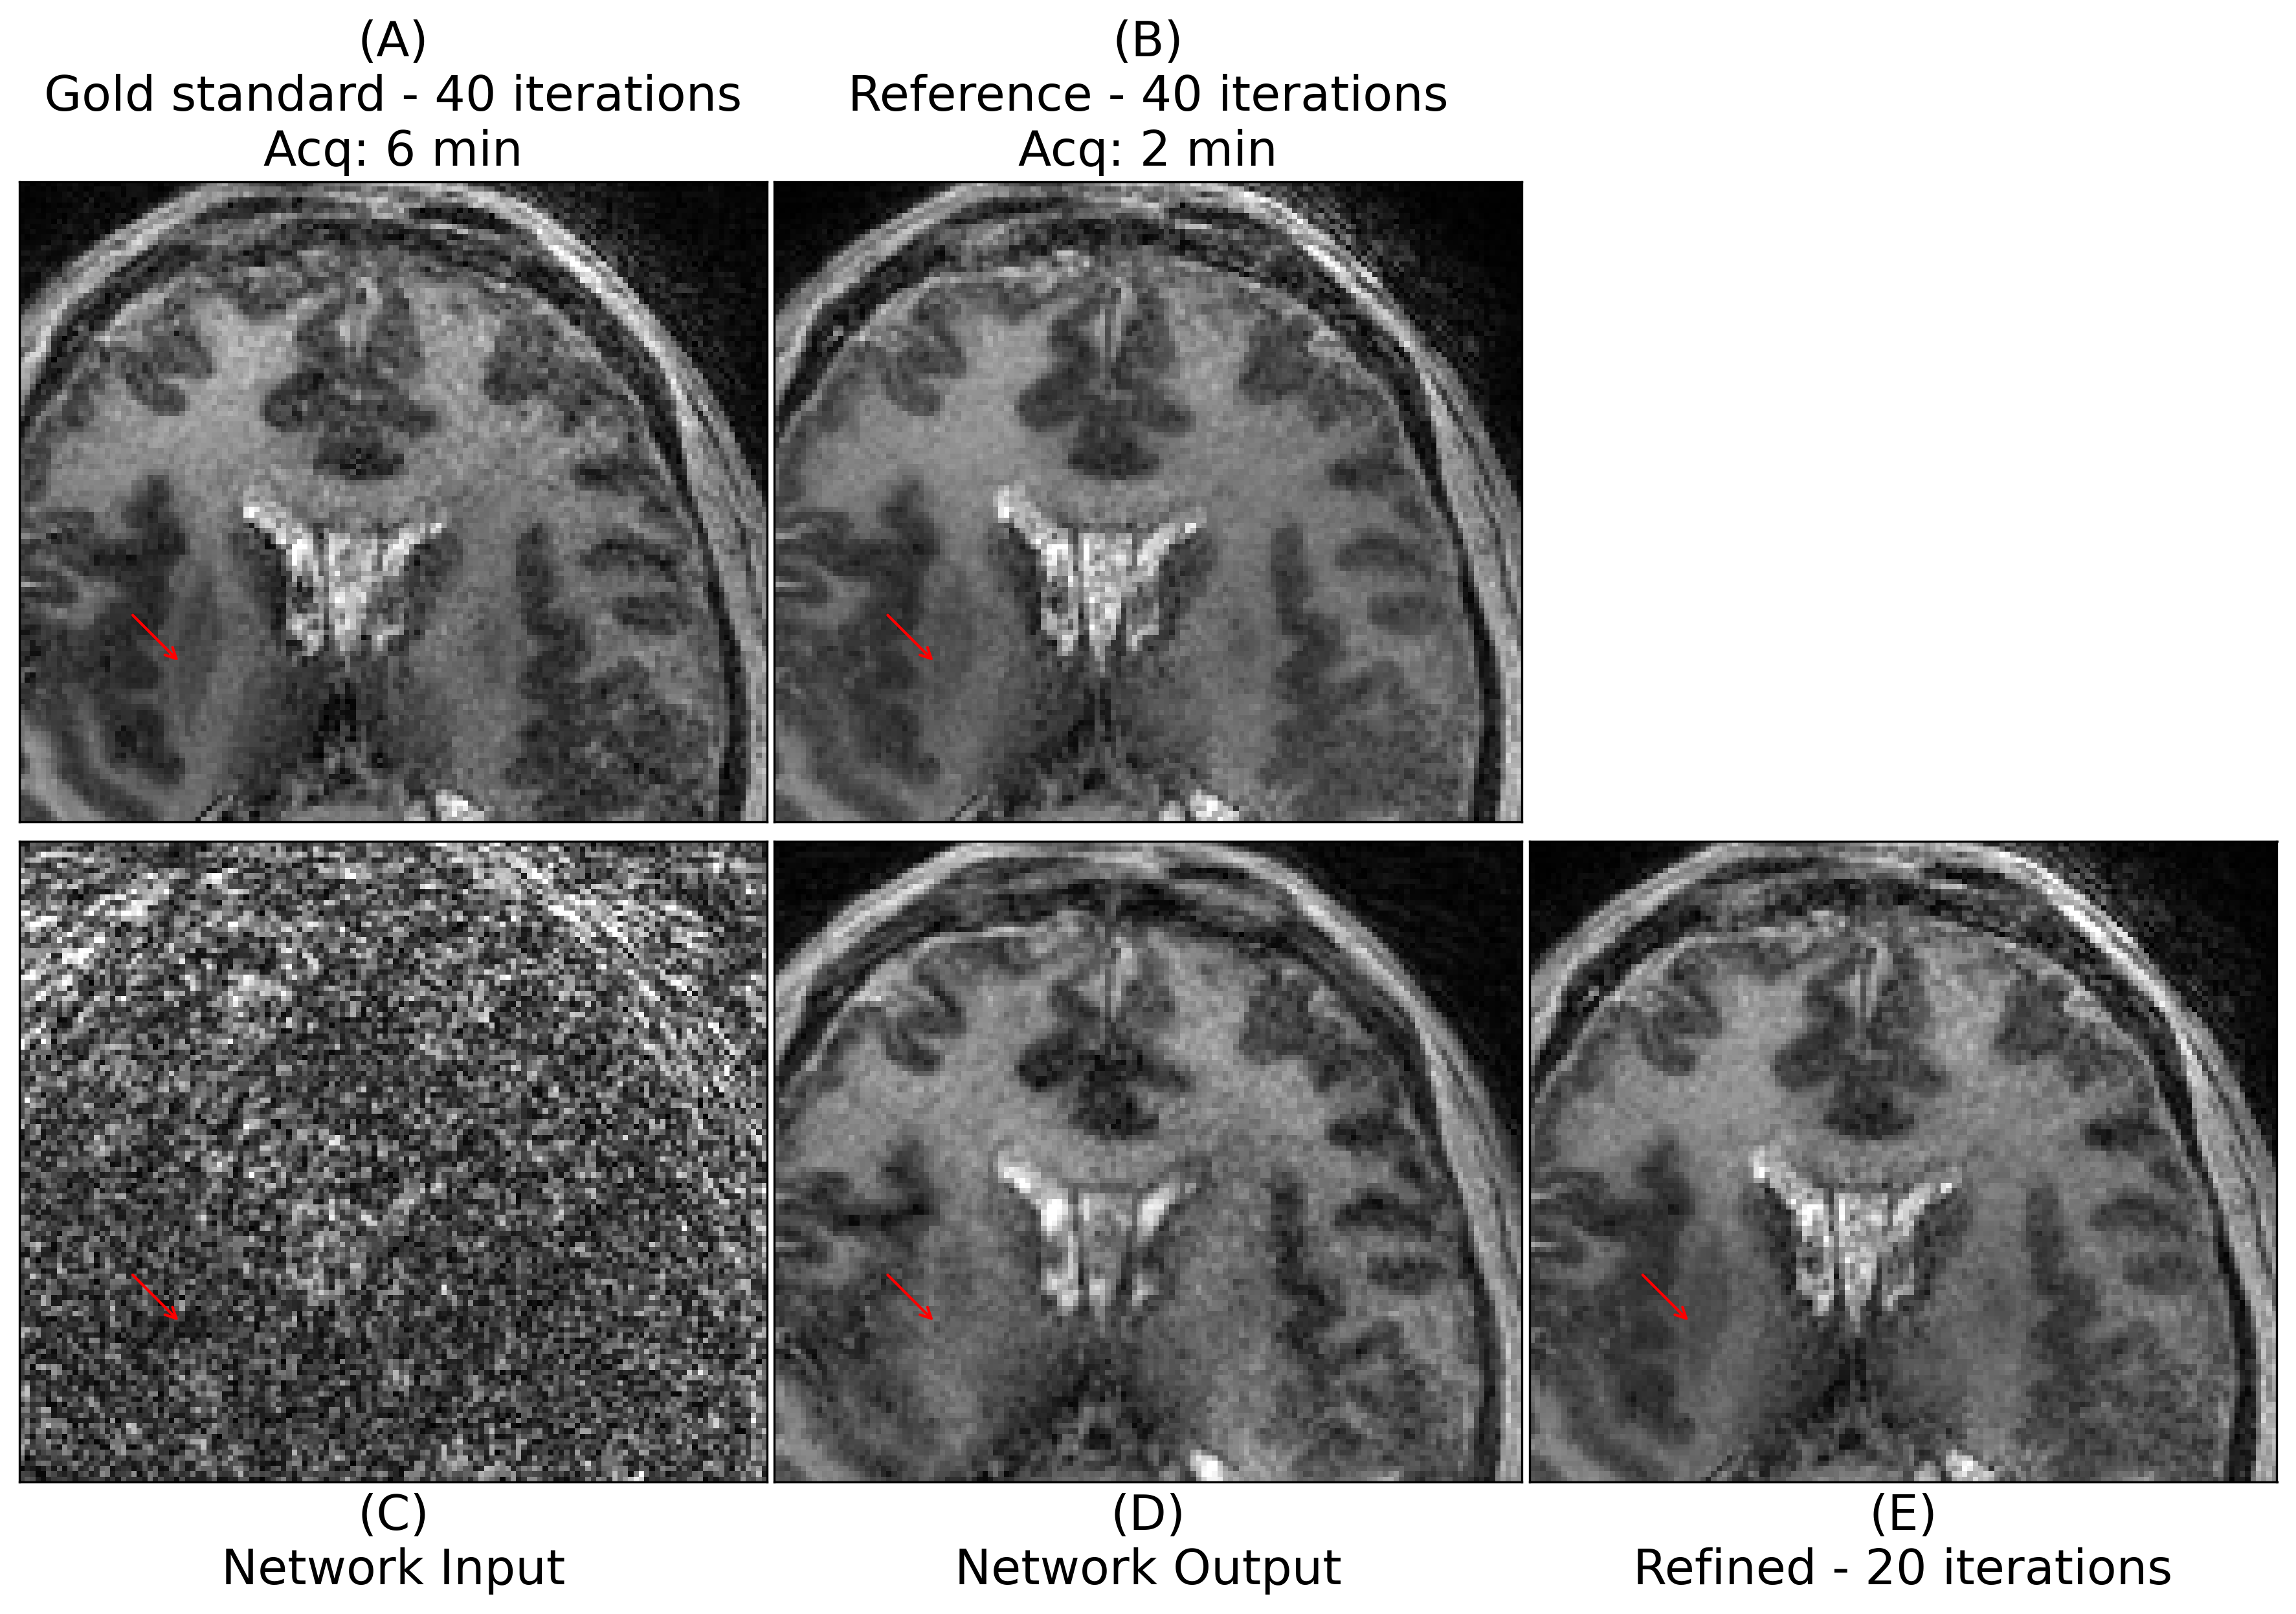

In [8]:
(fig, axs) = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

scale = [1, 2, 4, 6, 15]
c = 4
vmin = 0
vmax = 0.02

idx = (slice(30, 150), slice(75, 215))
jdx = (100, slice(None, None, -1), slice(None))

def f(x):
    tmp = coil_shading(x[(c,) + jdx])[idx]
    tmp = x[(c,) + jdx][idx]/tmp
    tmp = tmp/np.linalg.norm(tmp)
    return np.abs(tmp)

axs[0][0].imshow(f(r), cmap="gray", vmin=vmin, vmax=vmax)
axs[0][1].imshow(f(s), cmap="gray", vmin=vmin, vmax=vmax)
axs[1][0].imshow(f(t), cmap="gray", vmin=vmin, vmax=vmax)
axs[1][1].imshow(f(x), cmap="gray", vmin=vmin, vmax=vmax)
axs[1][2].imshow(f(z), cmap="gray", vmin=vmin, vmax=vmax)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.annotate("", xy=(30,90), xytext=(20,80), arrowprops=dict(arrowstyle="->",color="r"))

fig.delaxes(axs[0][2])

axs[0][0].set_title("(A)\nGold standard - 40 iterations\nAcq: 6 min",     fontsize=18)
axs[0][1].set_title("(B)\nReference - 40 iterations\nAcq: 2 min",     fontsize=18)
axs[1][0].set_xlabel("(C)\nNetwork Input", fontsize=18)
axs[1][1].set_xlabel("(D)\nNetwork Output",    fontsize=18)
axs[1][2].set_xlabel("(E)\nRefined - 20 iterations",           fontsize=18)

plt.subplots_adjust(wspace=0.01, hspace=-0.21)
plt.savefig('06_block.png')

In [9]:
# set up basis and dictionary for quantitative fitting
phi = loadmat("../data/shared/phi.mat")["phi"][:, :5]
phi = phi @ sp.fft(np.eye(phi.shape[-1]), axes=(0,))
mat = loadmat("../data/shared/dictionary.mat")

T1 = mat["T1"].ravel()
T2 = mat["T2"].ravel()
mat = mat["I_b"]
(T2, T1) = np.meshgrid(T2, T1)
T1 = T1.ravel()
T2 = T2.ravel()
mat = phi.conj().T @ np.reshape(mat, (-1, mat.shape[-1])).T
nrm = np.linalg.norm(mat, axis=0)
mat = np.array(mat/nrm[None, :],dtype=np.complex64)

In [10]:
def fit(x, dev, mat):
    dev = sp.Device(dev)
    xp = dev.xp
    with dev:
        mat = sp.to_device(mat, dev)
        x = sp.to_device(x, dev)
        
        x     = xp.abs(mat.conj().T @ x)
        lst_idx = sp.to_device(xp.argmax(x, axis=0), -1)
        
    fit_T1  = [T1[idx] for idx in lst_idx]
    fit_T2  = [T2[idx] for idx in lst_idx]

    return (fit_T1, fit_T2)

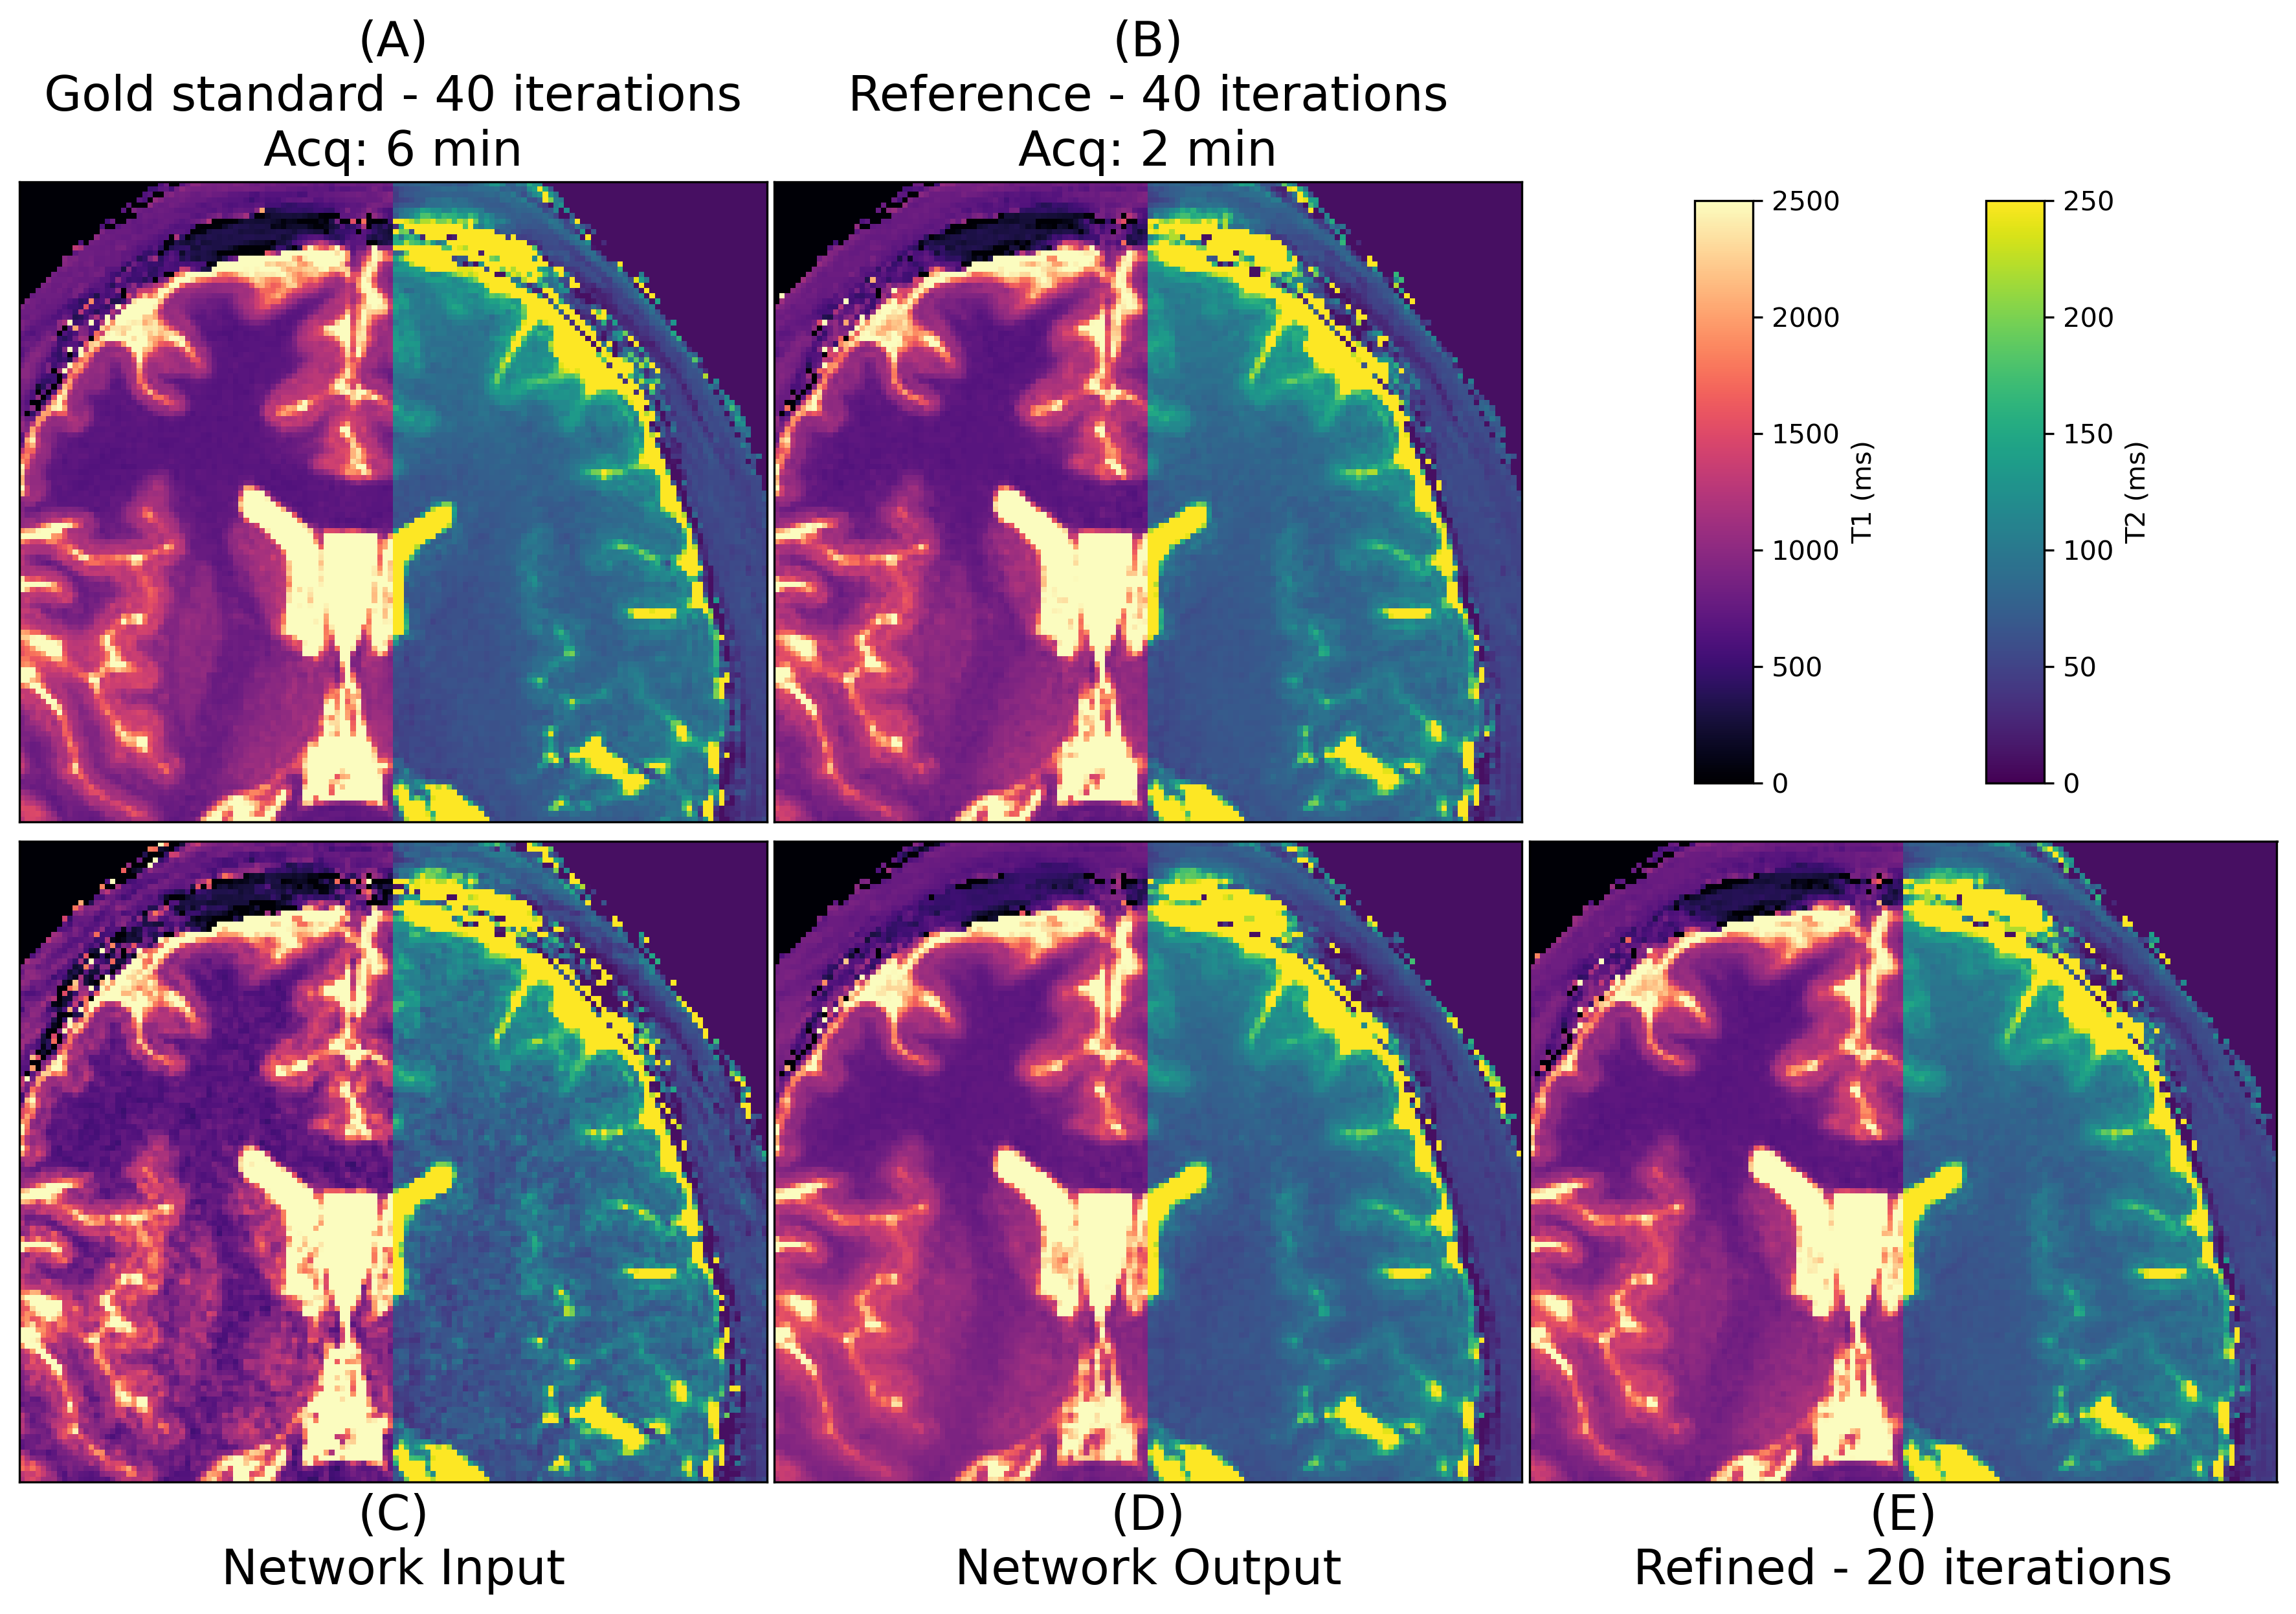

In [11]:
(fig, axs) = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
magn_thresh = 0.00005
msk = ((np.abs(x[0,...])/np.linalg.norm(x[0,...])) > magn_thresh)
dev = 0
c = slice(0,5)
vmin = 0
vmax = 2500

idx = (slice(30, 150), slice(75, 215))
jdx = (100, slice(None, None, -1), slice(None))

def f(x,ax):
    tmp = sp.ifft(x[(c,) + jdx][...,30:150,75:215],axes=(0,))
    tmp1=np.zeros(tmp.shape[1:])
    tmp2=np.zeros(tmp.shape[1:])
    for lin in range(tmp.shape[-1]):
        (tmp1[:,lin],tmp2[:,lin]) = fit(tmp[:,:,lin],  dev, mat)
    msk1 = np.zeros(tmp1.shape)
    msk1[:,:int(tmp1.shape[-1]/2)] = 1
    msk2 = np.zeros(tmp1.shape)
    msk2[:,int(tmp1.shape[-1]/2):] = 1
    data1 = np.ma.masked_array(tmp1,msk2)
    data2 = np.ma.masked_array(tmp2, msk1)
    im1 = ax.imshow(data1, cmap="magma", vmin=vmin, vmax=vmax)
    im2 = ax.imshow(data2, cmap="viridis", vmin=vmin, vmax=vmax/10)
    return (im1,im2)

f(np.array(r,dtype=np.complex64)*msk[None,...],axs[0][0])
f(np.array(s,dtype=np.complex64)*msk[None,...],axs[0][1])
f(np.array(t,dtype=np.complex64)*msk[None,...],axs[1][0])
f(np.array(x,dtype=np.complex64)*msk[None,...],axs[1][1])
(im1,im2) = f(z*msk[None,...],axs[1][2])

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

fig.delaxes(axs[0][2])

axs[0][0].set_title("(A)\nGold standard - 40 iterations\nAcq: 6 min",     fontsize=18)
axs[0][1].set_title("(B)\nReference - 40 iterations\nAcq: 2 min",     fontsize=18)
axs[1][0].set_xlabel("(C)\nNetwork Input", fontsize=18)
axs[1][1].set_xlabel("(D)\nNetwork Output",    fontsize=18)
axs[1][2].set_xlabel("(E)\nRefined - 20 iterations",           fontsize=18)

cb_ax = fig.add_axes([0.8, 0.52, 0.02, 0.3])
cbar = fig.colorbar(im2, cax=cb_ax)
cbar.set_label('T2 (ms)')

cb_ax2 = fig.add_axes([0.7, 0.52, 0.02, 0.3])
cbar = fig.colorbar(im1, cax=cb_ax2)
cbar.set_label('T1 (ms)')

plt.subplots_adjust(wspace=0.01, hspace=-0.21)
plt.savefig('07_quant_block.png')